In [4]:
#------------------------ Multi Layer Perceptron for multiclass classification - Sensors Dataset ------------------------

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


# load the dataset
df = pd.read_csv('/content/drive/MyDrive/Sensors/postgres_new_data_merged_5000_ae_cl2.csv')


In [5]:
# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = df['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
df = pd.concat([df, split_series], axis=1)

# Rename the split columns
df.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
df.drop('rv', axis=1, inplace=True)

df.head()

,tm,knt,ae,ae_cl,rv1,rv2,rv3,rv4,rv5,rv6,...,rv1491,rv1492,rv1493,rv1494,rv1495,rv1496,rv1497,rv1498,rv1499,rv1500
0,2022-09-17 08:03:23.942693,1500,0.500964,1,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029,...,29.0029,29.0029,29.0029,29.0029,29.0029,28.0028,29.0029,29.0029,29.0029,29.0029
1,2022-10-12 19:27:25.396487,1500,0.300354,0,26.0026,26.0026,26.0026,26.0026,26.0026,26.0026,...,26.0026,26.0026,26.0026,26.0026,26.0026,26.0026,26.0026,26.0026,26.0026,26.0026
2,2022-09-16 17:45:09.34245,1500,0.317388,0,29.0029,29.0029,29.0029,29.0029,29.0029,30.003,...,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029
3,2022-09-19 10:34:26.89874,1500,0.308470,0,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027,...,27.0027,26.0026,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027
4,2022-09-15 00:35:40.447517,1500,0.535184,1,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029,...,29.0029,29.0029,28.0028,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029,29.0029


In [6]:
X = df.loc[:, 'rv1':'rv1500'].astype(float).values
# X = df[col_names].astype(float).values
y = df['ae_cl']

# Create a mask that is True for non-nan values and False for nan values
mask = ~np.isnan(y)

# Apply the mask to both X and y
X = X[mask]
y = y[mask]

# Check the count of each class in y
print(np.unique(y, return_counts=True))

(array([0, 1, 2]), array([135, 117, 733]))


In [7]:

# ensure all data are floating point values
X = X.astype('float32')

# ensure all y data are integers
y = y.astype('int32')

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# determine the number of input features
n_features = X_train.shape[1]

print(n_features)


(659, 1500) (326, 1500) (659,) (326,)
1500


In [8]:
import tensorflow.keras as keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam

# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='softmax'))

# compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)

# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

# Save the model
model.save('model.keras')


Test Accuracy: 0.788


11/11 [==============================] - 0s 3ms/step
Total predictions per class: (array([2]), array([326]))


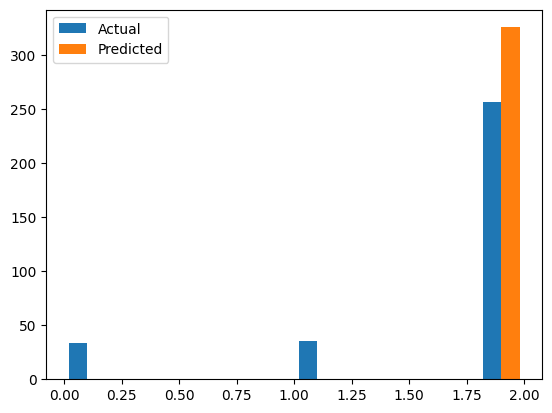

In [9]:
#------------------------ Analyze predictions ------------------------
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Create and print new df with actual and predicted value for test set
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Calculate difference between actual and predicted values
df['Difference'] = (df['Actual'] - df['Predicted'])

# save the new df
df.to_csv('predictions.csv')

# Check the count of each class in df['Predicted']
print("Total predictions per class:", np.unique(df['Predicted'], return_counts=True))


# Plot actual and predicted values with histogram
plt.hist([df['Actual'], df['Predicted']], label=['Actual', 'Predicted'])
plt.legend()
plt.show()

In [10]:

# make a prediction
#row = [5.1,3.5,1.4,0.2]
#yhat = model.predict([row])
#print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

# Neural Network with PCA

(659, 10) (326, 10) (659,) (326,)


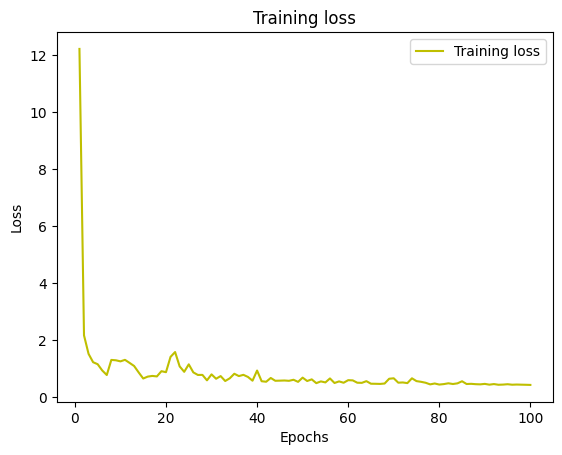

Test Accuracy: 0.801


In [11]:
from sklearn.decomposition import PCA

# SMOTE (Synthetic Minority Over-sampling Technique) is used to oversample the minority class

"""
from imblearn.over_sampling import SMOTE
!pip install imblearn


# SMOTE (Synthetic Minority Over-sampling Technique) is used to balance the dataset

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
sm = SMOTE(random_state = 2)

X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
"""

data = X
# define transform
pca = PCA(n_components=10)
# prepare transform on dataset
pca.fit(data)
# apply transform to dataset
transformed = pca.transform(data)

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

import tensorflow.keras as keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam

# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(10,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='softmax'))

# compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Print the loss for each epoch
loss = model.history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)


11/11 [==============================] - 0s 2ms/step
Total predictions per class: (array([0, 1, 2]), array([ 16,  24, 286]))
Accuracy: 0.8
Accuracy by class: {2: 1.0, 0: 0.14, 1: 0.31}


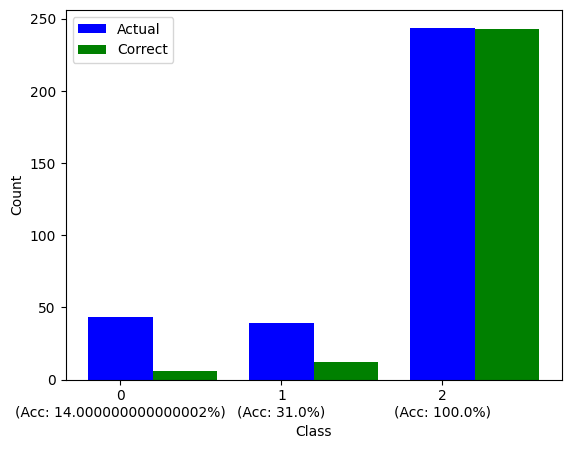

In [12]:
#------------------------ Analyze predictions ------------------------
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Create and print new df with actual and predicted value for test set
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Calculate difference between actual and predicted values
df['Difference'] = (df['Actual'] - df['Predicted'])

# save the new df
df.to_csv('predictions_pca.csv')

# Check the count of each class in df['Predicted']
print("Total predictions per class:", np.unique(df['Predicted'], return_counts=True))

# Calculate accuracy by comparing difference = 0 with total count
accuracy = (df['Difference'] == 0).sum() / len(df)
print("Accuracy:", accuracy.round(2))

# For each row in df, check if difference = 0 and then increment count per class
accuracy_by_class = {}
for index, row in df.iterrows():
  if row['Difference'] == 0:
    if row['Actual'] in accuracy_by_class:
      accuracy_by_class[row['Actual']] += 1
    else:
      accuracy_by_class[row['Actual']] = 1

# Get the total count of each class from the actual column
class_count = df['Actual'].value_counts()

# Loop through the dictionary and divide by the class count
for key, value in accuracy_by_class.items():
  accuracy_by_class[key] = (value / class_count[key]).round(2)

# Print accuracy by class
print("Accuracy by class:", accuracy_by_class)

# Get the unique classes from the actual column
classes = np.unique(df['Actual'])

# Create a figure and a subplot
fig, ax = plt.subplots()

# Loop through the classes
for c in classes:
  # Filter the rows where the actual class is c
  df_c = df[df['Actual'] == c]
  # Plot the actual values as blue bars
  # Use label only for the first class
  if c == classes[0]:
    ax.bar(c - 0.2, len(df_c), width=0.4, color='blue', label='Actual', align='edge')
  else:
    ax.bar(c - 0.2, len(df_c), width=0.4, color='blue', align='edge')
  # Filter the rows where the difference is zero (correct predictions)
  df_c_correct = df_c[df_c['Difference'] == 0]
  # Plot the correct predictions as green bars
  # Use label only for the first class
  if c == classes[0]:
    ax.bar(c + 0.2, len(df_c_correct), width=0.4, color='green', label='Correct', align='edge')
  else:
    ax.bar(c + 0.2, len(df_c_correct), width=0.4, color='green', align='edge')

# Set the x-axis ticks and labels to the classes
ax.set_xticks(classes)
# Create a list of labels with the accuracy values
labels = [f"{c}\n(Acc: {accuracy_by_class[c]*100}%)" for c in classes]
# Set the x-axis labels to the new labels
ax.set_xticklabels(labels)

# Set the x-axis and y-axis labels
ax.set_xlabel('Class')
ax.set_ylabel('Count')

# Add a legend
ax.legend()

# Show the plot
plt.show()
